## 0. Prerequisites

Load necessary Python libraries and define the directory where the data can be found.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers, _butter_lowpass, _align_trajectories_with_walking_direction
from lib.analysis import _get_gait_events_from_OMC
import os
from scipy.signal import find_peaks

In [2]:
# Set data directory
# PARENT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"  # on Linux
PARENT_FOLDER = "Z:\\Keep Control\\Data\\lab dataset"  # on Windows

# Get a list of participant ids
participant_ids = [folder_name for folder_name in os.listdir(PARENT_FOLDER) if folder_name.startswith("pp")]
print(f"Number of participants: {len(participant_ids)}")

Number of participants: 120


## 1. Get the data

In [3]:
# Trial to investigate
trial_name = "walk_preferred"

# Loop over the participants
for (ix_participant, participant_id) in enumerate(participant_ids[5:6]):

    # Get a list of OMC data files
    omc_filenames = [file_name for file_name in os.listdir(os.path.join(PARENT_FOLDER, participant_id, "optical")) if file_name.endswith(".mat")]

    # Select only the file corresponding to the trial of interest
    ix_omc_filename = [ix for ix in range(len(omc_filenames)) if ("walk_preferred" in omc_filenames[ix])]
    if len(ix_omc_filename) > 0:
        ix_omc_filename = ix_omc_filename[0]
        omc_filename = omc_filenames[ix_omc_filename]

        # Check if there is an equivalent IMU file
        if os.path.isfile(os.path.join(PARENT_FOLDER, participant_id, "imu", omc_filename.replace("omc_", "imu_"))):
            imu_filename = omc_filename.replace("omc_", "imu_")

            # Load the data
            omc_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "optical", omc_filename))
            imu_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "imu", imu_filename))
print(f"Participant: {participant_id}")

Participant: pp006


## 2. Preprocess the data
Get the data sampling frequency, and explore the number of time steps (frames) and the number of markers used. Then, account for any gaps in the marker data by filling gaps based on marker intercorrelations. Low-pass filter the marker data to reduce the effects of high-frequency noise. Finally, align the marker trajectories with the main direction of walking.

In [4]:
# Get sampling frequency
fs = omc_data["fs"]
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 200 Hz


In [5]:
# Get marker position data, and data dimensions
raw_data = omc_data["pos"][:,:3,:]
n_time_steps, n_dimensions, n_markers = raw_data.shape

# Reshape data to (n_time_steps, n_dimensions * n_markers)
raw_data = np.reshape(raw_data, (n_time_steps, n_dimensions*n_markers), order="F")

# Fill gaps in marker data
filled_data = _predict_missing_markers(raw_data)

# Low-pass filter, and reshape back to original shape
filtered_data = _butter_lowpass(filled_data, fs)
filtered_data = np.reshape(filtered_data, (n_time_steps, n_dimensions, n_markers), order="F")

# Align data with main direction of walking
aligned_data = _align_trajectories_with_walking_direction(filtered_data, omc_data["marker_location"])

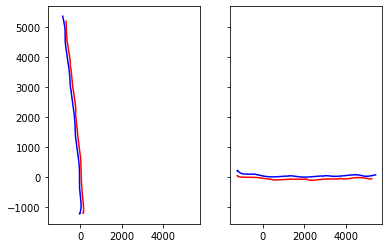

In [9]:
# Visualize
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].plot(filtered_data[:,0,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], filtered_data[:,1,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], 'b-')
axs[0].plot(filtered_data[:,0,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], filtered_data[:,1,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], 'r-')
axs[1].plot(aligned_data[:,0,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], aligned_data[:,1,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], 'b-')
axs[1].plot(aligned_data[:,0,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], aligned_data[:,1,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], 'r-')
plt.show()